
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 8 (демо)
## <center> Реализация алгоритмов онлайн-обучения

Вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://docs.google.com/forms/d/1xlbc0CaUaNpVs-fhxkHUe61AtsvS_aDqQ0CLFxs6UDA) для ответов.

## План домашнего задания
    1. Линейная регрессия и SGD
    2. Логистическая регрессия и SGD
    3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

##  1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [2]:
class OnlineRegressor(BaseEstimator):
    
    def __init__(self, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        w = np.zeros(X.shape[1])

        for it in tqdm(range(self.n_iter)):
            for i in range(X.shape[0]):

                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]
                w = new_w.copy()

                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))

        self.w_ = self.weights_[np.argmin(self.mse_)]

        return self
                  
    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        return X.dot(self.w_)
                  

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [3]:
data_demo = pd.read_csv("../../data/weights_heights.csv")

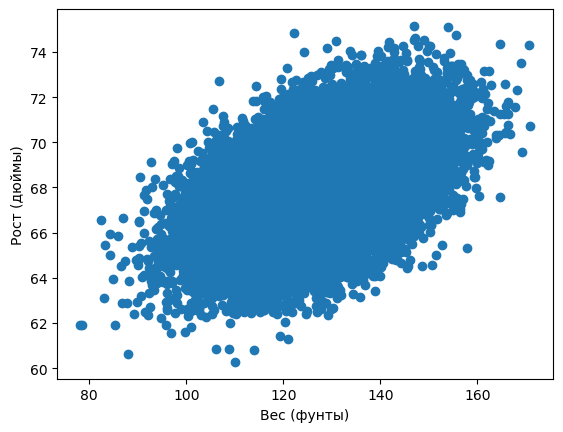

In [4]:
plt.scatter(data_demo["Weight"], data_demo["Height"])
plt.xlabel("Вес (фунты)")
plt.ylabel("Рост (дюймы)");

In [5]:
X, y = data_demo["Weight"].values, data_demo["Height"].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [8]:
oreg = OnlineRegressor()
oreg.fit(X_train_scaled, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.48s/it]


,eta,0.001
,n_iter,10


Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

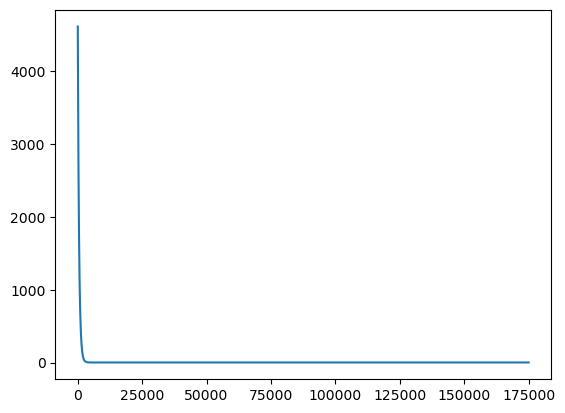

In [9]:
plt.plot(range(len(oreg.mse_)), oreg.mse_);

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [10]:
np.min(oreg.mse_), oreg.w_

(np.float64(2.7151352406643623), array([67.9898497 ,  0.94447605]))

Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

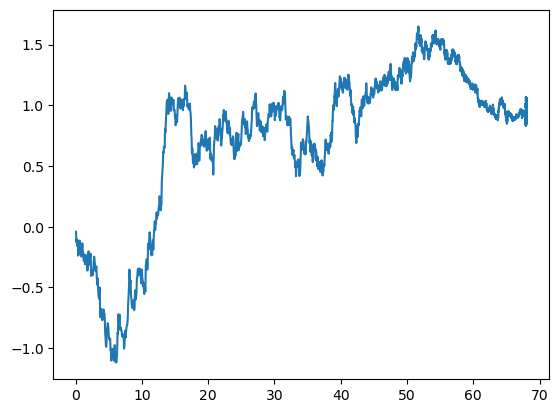

In [11]:
plt.plot([w[0] for w in oreg.weights_], 
         [w[1] for w in oreg.weights_]);

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [12]:
mean_squared_error(y_valid, oreg.predict(X_valid_scaled))

2.6708681207033784

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [13]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train_scaled, y_train)
lm.coef_, lm.intercept_

(array([0.94537278]), np.float64(67.98930834742858))

In [14]:
mean_squared_error(y_valid, lm.predict(X_valid_scaled))

2.6708307676676344

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5

- Ответ: 5

## 2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

- Ответ:  - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [15]:
def sigma(z):
    # Преобразуем z в массив, даже если это скаляр
    z = np.array(z, ndmin=1)
    z[z > 100] = 100
    z[z < -100] = -100
    return 1 / (1 + np.exp(-z))

In [16]:
class OnlineClassifier(BaseEstimator):
    
    def __init__(self, C=1, eta=1e-3, n_iter=10):
        self.eta = eta
        self.C = C
        self.n_iter = n_iter
        self.loss_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])  # добавляем bias
        w = np.ones(X.shape[1])
        
        for it in tqdm(range(self.n_iter), desc="Epochs"):
            for i in range(X.shape[0]):
                new_w = w.copy()
                # Обновление bias
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                
                # Обновление остальных весов
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (
                        self.C * y[i] * X[i, j] * sigma(-y[i] * w.dot(X[i, :])) - w[j]
                    )
                w = new_w.copy()
            
            # Считаем log-loss на всей выборке для текущего состояния весов
            self.loss_.append(log_loss(y, sigma(X.dot(w))))
            self.weights_.append(w.copy())
    
        # Берем веса с минимальной функцией потерь
        self.w_ = self.weights_[np.argmin(self.loss_)]
        return self
                  
    def predict_proba(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        p_vec = sigma(X.dot(self.w_)).reshape([X.shape[0], 1])
        return np.hstack([1 - p_vec, p_vec])
    
    def predict(self, X):
        pred_probs = self.predict_proba(X)[:, 1]
        signs = np.sign(pred_probs - 0.5)
        signs[np.where(signs == 0)] = 1  # если p = 0.5
        return signs.astype(int)

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [17]:
from sklearn.datasets import load_breast_cancer

In [18]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [21]:
oclf = OnlineClassifier(C=1, n_iter=3, eta=1e-3)
oclf.fit(X_train_scaled, y_train)

Epochs:   0%|                                                                                    | 0/3 [00:00<?, ?it/s]C:\Users\nabie\AppData\Local\Temp\ipykernel_10528\4271903874.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_w[j] += self.eta * (
Epochs:  33%|█████████████████████████▎                                                  | 1/3 [00:00<00:00,  3.02it/s]C:\Users\nabie\AppData\Local\Temp\ipykernel_10528\4271903874.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_w[j] += self.eta * (
Epochs:  67%|██████████████████████████████████████████████████▋                         | 2/3 [00:00<00:00,  3.39it/s]C:\Users\na

,C,1
,eta,0.001
,n_iter,3


Постройте график изменения log_loss.

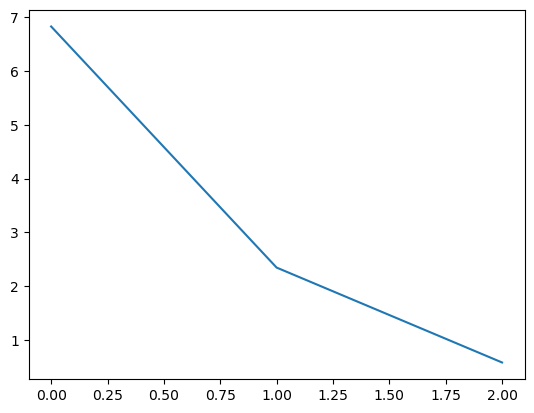

In [22]:
plt.plot(range(len(oclf.loss_)), oclf.loss_);

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [23]:
oclf = OnlineClassifier(C=1000, n_iter=10, eta=1e-3)
oclf.fit(X_train_scaled, y_train)

Epochs:   0%|                                                                                   | 0/10 [00:00<?, ?it/s]C:\Users\nabie\AppData\Local\Temp\ipykernel_10528\4271903874.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_w[j] += self.eta * (
Epochs:  10%|███████▌                                                                   | 1/10 [00:00<00:02,  3.74it/s]C:\Users\nabie\AppData\Local\Temp\ipykernel_10528\4271903874.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_w[j] += self.eta * (
Epochs:  20%|███████████████                                                            | 2/10 [00:00<00:02,  3.52it/s]C:\Users\na

,C,1000
,eta,0.001
,n_iter,10


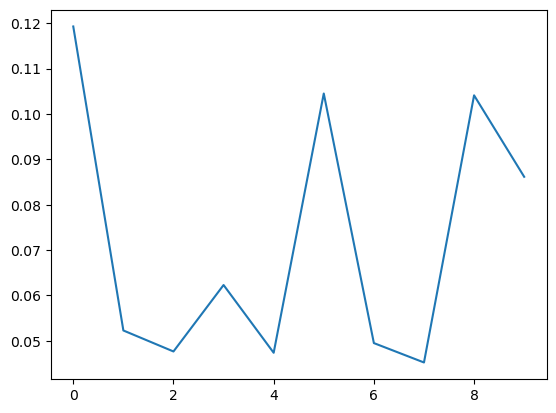

In [24]:
plt.plot(range(len(oclf.loss_)), oclf.loss_);

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension
 - radius error

In [25]:
best_w = oclf.weights_[np.argmin(oclf.loss_)]

In [26]:
np.min(best_w), np.max(best_w)

(np.float64(-3.6619048811719654), np.float64(3.590978144691181))

In [27]:
pd.DataFrame({'coef': best_w,
             'feat': ['intercept'] + list(cancer.feature_names)}).sort_values(by='coef')

,coef,feat
11,-3.661905,radius error
14,-3.404619,area error
24,-3.248342,worst area
8,-3.209479,mean concave points
22,-3.164022,worst texture
21,-2.955341,worst radius
7,-2.846719,mean concavity
27,-2.678827,worst concavity
25,-2.368090,worst smoothness
23,-1.840024,worst perimeter


In [28]:
cancer.feature_names[np.argmin(best_w)-1]

np.str_('radius error')

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [29]:
roc_auc_score(y_valid, oclf.predict_proba(X_valid_scaled)[:,1])

0.9858420268256334

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
logit = LogisticRegression(random_state=17).fit(X_train_scaled, y_train)

In [32]:
cancer.feature_names[np.argmin(logit.coef_.flatten())]

np.str_('radius error')

In [33]:
log_loss(y_valid, logit.predict_proba(X_valid_scaled)[:,1])

0.10855482881319026

In [34]:
roc_auc_score(y_valid, logit.predict_proba(X_valid_scaled)[:,1])

0.9885245901639343

## 3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://drive.google.com/open?id=1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [35]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [38]:
reviews_train = load_files(
    "../../data/train",
    categories=['pos', 'neg']
)
text_train, y_train = reviews_train.data, reviews_train.target


In [39]:

reviews_test = load_files(
    "../../data/test",
    shuffle=True
)
text_test = reviews_test.data[:5000]
y_test = reviews_test.target[:5000]

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [41]:
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

In [42]:
X_train.shape, X_test.shape

((25000, 1513832), (5000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import time

# инициализация модели
logit = LogisticRegression(random_state=17, max_iter=1000)

# замер времени обучения
start_time = time.time()
logit.fit(X_train, y_train)
train_time = time.time() - start_time

# предсказание вероятностей для ROC AUC
y_test_proba = logit.predict_proba(X_test)[:, 1]

# ROC AUC
roc_auc = roc_auc_score(y_test, y_test_proba)

train_time, roc_auc


(65.77705717086792, 0.9575030912079133)

Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска
 - Реализован линейный SVM
 - Реализована ранняя остановка во избежание переобучения
 - Есть распараллеливание по процессорам
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)

- Ответ: Изменяемый шаг градиентного спуска
Реализован линейный SVM
Есть распараллеливание по процессорам
Можно обучать LASSO


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [47]:
sgd_logit = SGDClassifier(loss='log_loss', random_state=17,
                          max_iter=100)

In [48]:
sgd_logit.fit(X_train, y_train)

,loss,'log_loss'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,100
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [49]:
roc_auc_score(y_test, sgd_logit.predict_proba(X_test)[:, 1])

0.9524313982243794

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - 3
 - 4
 - 5
- Ответ: 3